## Importing the libraries

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import pathlib
# pathlib.Path().resolve()

In [3]:
dataset = pd.read_csv('./Datasets/Breastcancer.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [4]:
dataset.shape

(158, 13583)

## Taking care of missing data

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:, :-1])
X[:, :-1] = imputer.transform(X[:, :-1])

In [6]:
print(X)

[[ 0.425 -0.316  0.465 ...  0.323 -0.4    0.064]
 [ 0.694 -0.497  0.2   ...  0.505 -0.275  0.3  ]
 [ 0.304 -0.205  0.739 ...  0.047 -0.98   0.233]
 ...
 [ 0.041  0.038  0.774 ...  0.298 -0.679  0.099]
 [ 0.139 -0.353  0.643 ... -0.144 -0.467  0.344]
 [-0.04   0.01   1.086 ...  1.654 -1.363  0.28 ]]


### Encoding the Dependent Variable

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4]


### Min-Max scaling

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)

### Information gain feature selection

In [10]:
from sklearn.feature_selection import mutual_info_classif

In [11]:
importances = mutual_info_classif(X_train_minmax, y)
feat_importances = pd.Series(importances, dataset.columns[0:len(dataset.columns)-1])

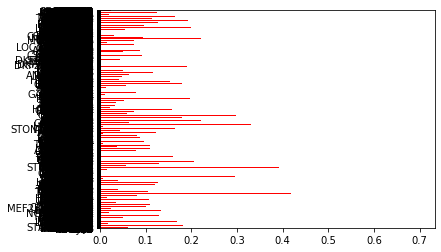

In [12]:
feat_importances.plot(kind='barh', color='red')
plt.show()
# This will take time to run, so be patient or comment it out as it's just a graph

In [13]:
X = dataset.drop('Class',axis=1)
y = dataset['Class']

In [14]:
print(y)
print(y.unique())

0       Basal
1       Basal
2       Basal
3       Basal
4       Basal
        ...  
153    Normal
154    Normal
155    Normal
156    Normal
157    Normal
Name: Class, Length: 158, dtype: object
['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


In [15]:
from sklearn.feature_selection import SelectKBest

In [16]:
cols_selector = SelectKBest(mutual_info_classif, k=300)
X_kbest = cols_selector.fit_transform(X_train_minmax, y)
print(X_kbest)

[[0.15244293 0.70728291 0.15461672 ... 0.92623815 0.02029447 0.16934932]
 [0.09867719 0.49789916 0.13937282 ... 0.61222339 0.53243136 0.09434932]
 [0.08118199 0.92950514 0.2158101  ... 0.43238497 0.53521687 0.14537671]
 ...
 [0.59409004 0.86741363 0.42857143 ... 0.38180541 0.30362117 0.48202055]
 [0.37177299 0.36671335 0.50261324 ... 0.4116614  0.11619578 0.4744863 ]
 [0.41263068 0.67553688 0.41093206 ... 0.97541272 0.31078392 0.50325342]]


In [17]:
print('Original number of features:', X.shape)
print('Reduced number of features:', X_kbest.shape)

Original number of features: (158, 13582)
Reduced number of features: (158, 300)


### SVM with rbf kernel

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size = 0.2, random_state = 42)

In [19]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 42, decision_function_shape='ovo')
classifier.fit(X_train, y_train)

SVC(decision_function_shape='ovo', random_state=42)

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[9 0 0 0 0]
 [0 3 0 0 0]
 [0 0 9 0 1]
 [0 0 1 5 0]
 [0 2 0 0 2]]
0.875


### 10-fold cross validation

In [21]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 87.18 %
Standard Deviation: 7.71 %


c:\users\farha\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


### Metrics calculation

In [22]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(FP)
print(FN)
print(TP)
print(TN)



[0 2 1 0 1]
[0 0 1 1 2]
[9 3 9 5 2]
[23 27 21 26 27]


In [23]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


In [25]:
avg_PPV  = np.average(PPV, axis=None, weights=None, returned=False)
avg_NPV  = np.average(NPV, axis=None, weights=None, returned=False)
avg_TPR  = np.average(TPR, axis=None, weights=None, returned=False)
avg_TNR  = np.average(TNR, axis=None, weights=None, returned=False)
avg_ACC  = np.average(ACC, axis=None, weights=None, returned=False)
print("PPV:{:.2f}\nNPV:{:.2f}\nSensitivity:{:.2f}\nSpecificity:{:.2f}\nAccuracy:{:.2f}".format(avg_PPV, avg_NPV, avg_TPR, avg_TNR, avg_ACC))

PPV:0.83
NPV:0.97
Sensitivity:0.85
Specificity:0.97
Accuracy:0.95
